# Monte Carlo Portfolio Optimization

This notebook handles data acquisition, loading, and comprehensive analysis for portfolio optimization using Monte Carlo simulations.

## 1. Setup and Configurations

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create data directory if it doesn't exist
os.makedirs("../data", exist_ok=True)

## 2. Data Acquisition

Fetching adjusted close prices for selected assets.

In [19]:
tickers = ["AAPL", "MSFT", "GOOGL", "SPY"]

print("Downloading data...")
data = yf.download(
    tickers,
    start="2020-01-01",
    end="2025-12-31",
    auto_adjust=True,
    progress=False
)

# Handle Multi-Index columns
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"]

data_to_save = data.reset_index()
output_path = "../data/asset_prices.csv"
data_to_save.to_csv(output_path, index=False)

print(f"✅ Saved: {output_path}")
data.head()

✅ Saved: ../data/asset_prices.csv


Ticker,AAPL,GOOGL,MSFT,SPY
Date,,,,
2020-01-02,72.400513,67.920815,152.505707,297.698883
2020-01-03,71.696632,67.565475,150.606735,295.444733
2020-01-06,72.267937,69.366386,150.995987,296.571838
2020-01-07,71.928040,69.232399,149.619293,295.737915
2020-01-08,73.085121,69.725174,152.002441,297.314117


## 3. Data Loading & Preprocessing

In [20]:
def load_processed_data(file_path):
    df = pd.read_csv(file_path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    return df

prices = load_processed_data("../data/asset_prices.csv")
print("Data loaded successfully.")

Data loaded successfully.


# 4 . Statistical Estimation


In [26]:
# ============================================================
# 4. Statistical Estimation of Returns (PHASE 1)
# ============================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ----- 1️⃣ Compute Log Returns -----
returns = np.log(prices / prices.shift(1)).dropna()

print("Returns computed successfully.")
returns.head()


Returns computed successfully.


,AAPL,GOOGL,MSFT,SPY
Date,,,,
2020-01-03,-0.009770,-0.005245,-0.012530,-0.007601
2020-01-06,0.007937,0.026305,0.002581,0.003808
2020-01-07,-0.004714,-0.001933,-0.009159,-0.002816
2020-01-08,0.015959,0.007092,0.015803,0.005316
2020-01-09,0.021018,0.010443,0.012416,0.006758


In [27]:
# ----- 2️⃣ Estimate Statistical Properties -----

trading_days = 252

mean_returns = returns.mean()
annualized_mean = mean_returns * trading_days

volatility = returns.std()
annualized_volatility = volatility * np.sqrt(trading_days)

cov_matrix = returns.cov()
annualized_cov = cov_matrix * trading_days

correlation_matrix = returns.corr()

skewness = returns.skew()
kurtosis = returns.kurtosis()

# Combine into one summary table
summary_stats = pd.DataFrame({
    "Mean (Daily)": mean_returns,
    "Mean (Annualized)": annualized_mean,
    "Volatility (Daily)": volatility,
    "Volatility (Annualized)": annualized_volatility,
    "Skewness": skewness,
    "Kurtosis": kurtosis
})

print("Summary Statistics:")
display(summary_stats)


Summary Statistics:


,Mean (Daily),Mean (Annualized),Volatility (Daily),Volatility (Annualized),Skewness,Kurtosis
AAPL,0.000881,0.221984,0.020000,0.317487,0.028422,6.462132
GOOGL,0.001016,0.256112,0.020460,0.324797,-0.168956,3.695308
MSFT,0.000772,0.194446,0.018612,0.295464,-0.163929,7.872108
SPY,0.000555,0.139933,0.013103,0.208008,-0.560028,13.435623


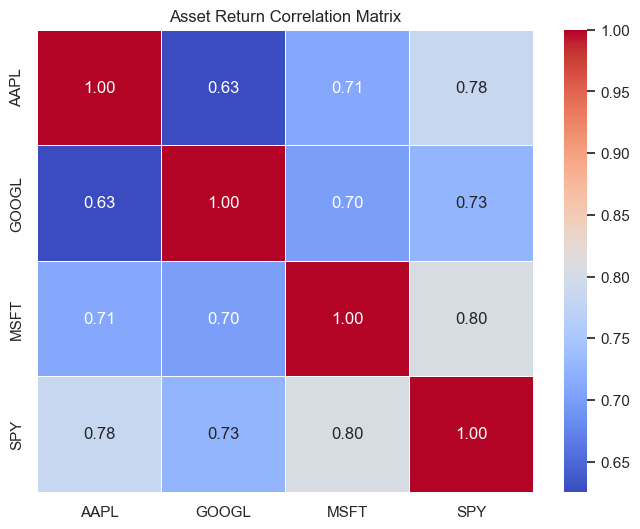

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap="coolwarm", 
            fmt=".2f",
            linewidths=0.5)

plt.title("Asset Return Correlation Matrix")
plt.show()


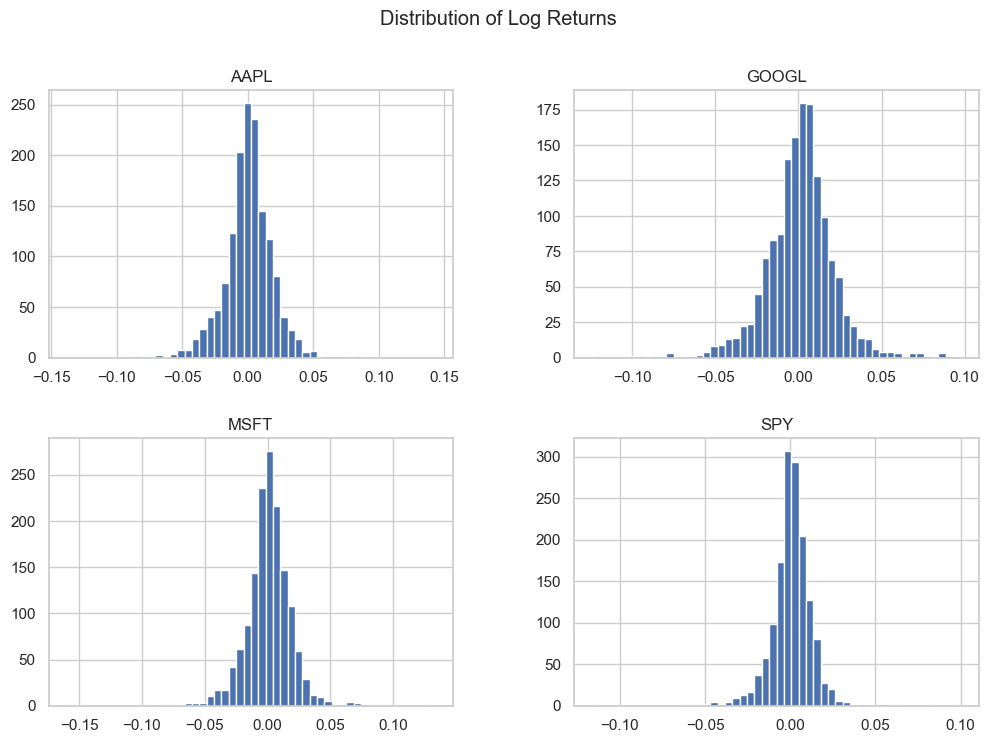

In [29]:
returns.hist(bins=50, figsize=(12,8))
plt.suptitle("Distribution of Log Returns")
plt.show()


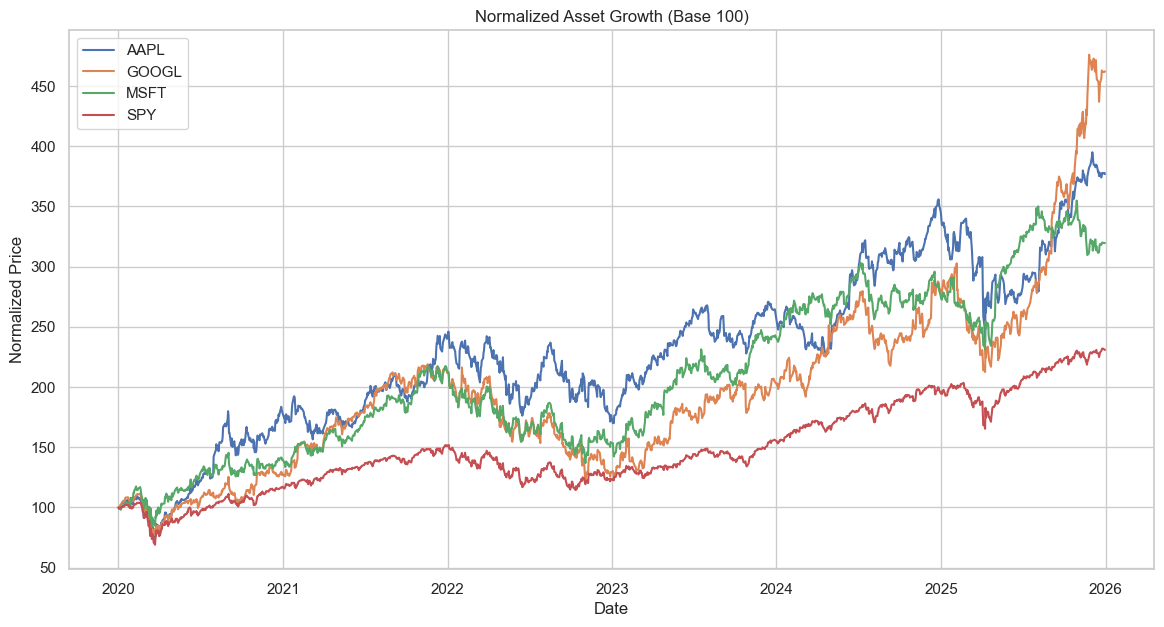

In [31]:
# Normalize prices to start at 100 for comparison
normalized_prices = (prices / prices.iloc[0]) * 100

plt.figure(figsize=(14, 7))
for asset in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[asset], label=asset)

plt.title("Normalized Asset Growth (Base 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

### 5.1 Drawdown Curve

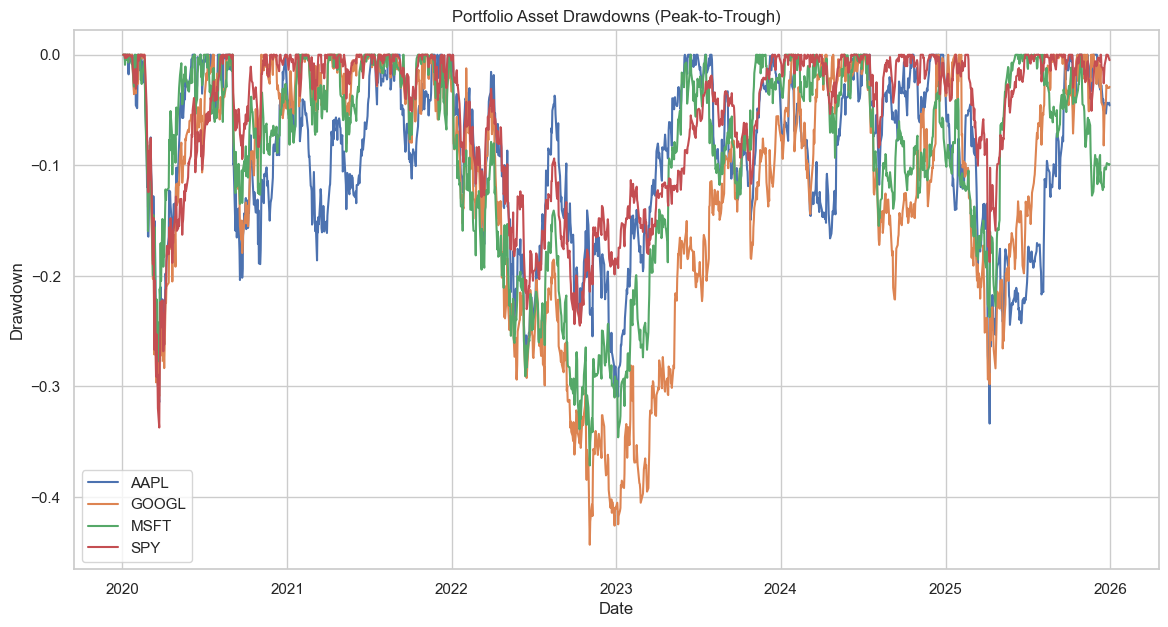

In [23]:
cumulative_returns = (1 + log_returns).cumprod()
peak = log_returns.cumsum().apply(np.exp).expanding(min_periods=1).max()
drawdown = (log_returns.cumsum().apply(np.exp) / peak) - 1

plt.figure(figsize=(14, 7))
for asset in drawdown.columns:
    plt.plot(drawdown.index, drawdown[asset], label=asset)

plt.title("Portfolio Asset Drawdowns (Peak-to-Trough)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.show()

## 6. Monte Carlo Simulation for Portfolio Optimization

In [24]:
num_portfolios = 10000
all_weights = np.zeros((num_portfolios, len(tickers)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    # Weights
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[i, :] = weights
    
    # Expected Return
    ret_arr[i] = np.sum((log_returns.mean() * weights) * 252)
    
    # Expected Volatility
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

max_sharpe_idx = sharpe_arr.argmax()
print(f"Best Sharpe Ratio: {sharpe_arr[max_sharpe_idx]:.2f}")
print(f"Weights for Optimal Portfolio: {dict(zip(tickers, all_weights[max_sharpe_idx, :]))}")

Best Sharpe Ratio: 0.83
Weights for Optimal Portfolio: {'AAPL': np.float64(0.3339774155355921), 'MSFT': np.float64(0.6102728073822857), 'GOOGL': np.float64(0.0396997495833579), 'SPY': np.float64(0.016050027498764344)}


## 7. Efficient Frontier Visualization

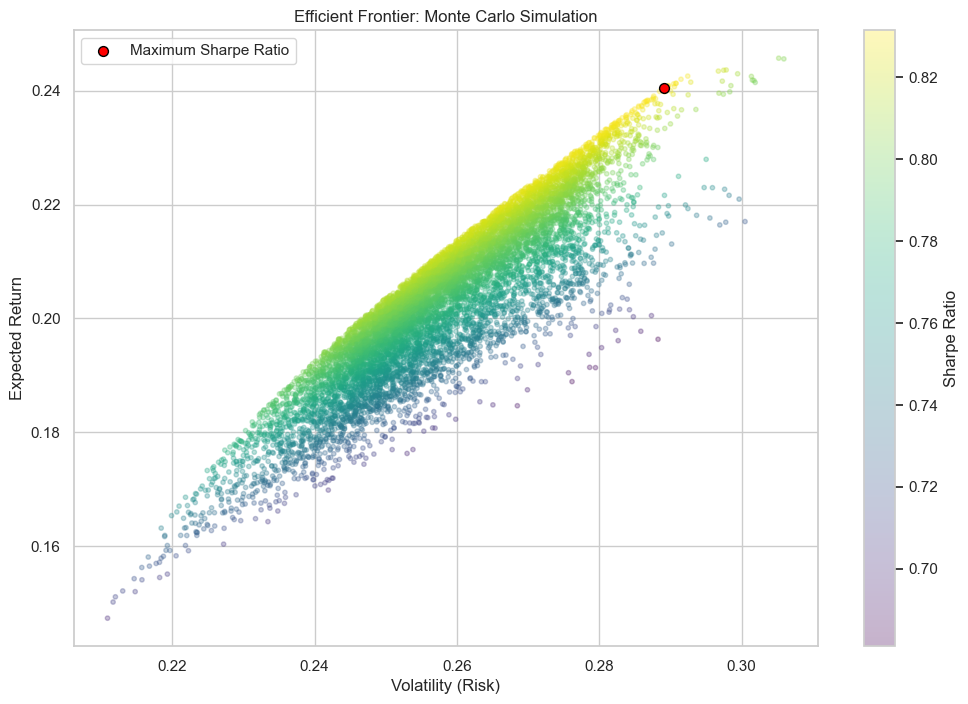

In [25]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr[max_sharpe_idx], ret_arr[max_sharpe_idx], c='red', s=50, edgecolors='black', label='Maximum Sharpe Ratio')

plt.title('Efficient Frontier: Monte Carlo Simulation')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()